In [1]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
from wordcloud import WordCloud
from gensim.parsing import remove_stopwords

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

from nltk.stem import WordNetLemmatizer



In [2]:
def clean_data(text):    
    text = re.sub('@[\w]*', '', text)   # remove @user
    text = re.sub('&amp;','',text)             # remove &amp;
    text = re.sub('[?!.;:,,#@-]', '', text)  # remove special characters
    text = re.sub(r'[^\x00-\x7F]+', '', text) # remove Unicode characters
    text = text.replace("[^A-Za-z]", "") # Replace everything except alphabets
    text = text.lower() # make everything lowercase for uniformity    
    # removing stop-words eg. 'we', 'our', 'ours', 'ourselves', 'just', 'don', "don't", 'should'
    text = remove_stopwords(text)    
    return text

# split each tweet into words, then lemmatize each word and rejoin them to a sentence
def lemmatize_text(text):
    words = text.split()
    lemm = WordNetLemmatizer()
    lemmatized_words = [lemm.lemmatize(word) for word in words]    
    return "".join(lemmatized_words)

    
def plot_model(history):
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    acc = hist['accuracy']
    loss = hist['loss']
    val_acc = hist['val_accuracy']
    val_loss = hist['val_loss']
    auc = hist['auc']
    val_auc = hist['val_auc']
    
    plt.figure()
    plt.plot(epochs,loss)
    plt.plot(epochs, val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()
    
    plt.figure()
    plt.plot(epochs, acc, label='accuracy')
    plt.plot(epochs,val_acc, label='val_accuracy')
    plt.legend()
    plt.show()
    
    
    plt.figure()
    plt.plot(epochs, auc, label='AUC')
    plt.plot(epochs,val_auc, label='val_AUC')
    plt.legend()
    plt.show()
    



In [3]:
# this class will be used to reset the state of the model after every epoch
# this will be used along with the learning rate scheduler
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()
        



In [4]:
# *************************  read training data *******************************
df = train_tweets = pd.read_csv("/Users/abhilashyelahankaramanjaneya/Desktop/Machine_learning_projects/Projects/Datasets/twitter-train.csv", sep=',')

print(df.head())

df.drop('id', axis=1, inplace=True)
df.drop_duplicates()
print(df.isna().sum())

tweets = df['tweet']
label = df['label']

tweets = tweets.apply(lambda x: clean_data(x))



   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
label    0
tweet    0
dtype: int64


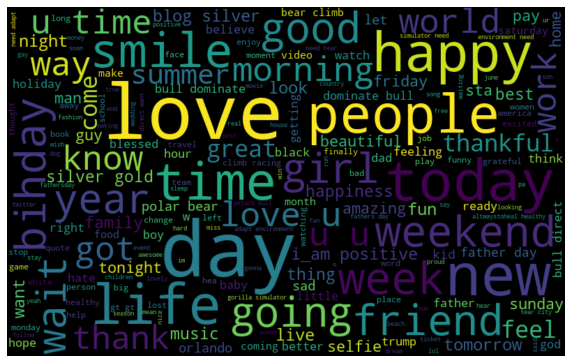

In [5]:
# Now we normaize the words using lemmatization
# tweets = tweets.apply(lambda tweet: lemmatize_text(tweet))
# Note - we find that the scores decrese when we use lemmatization

# *********************** Exploratory data analysis ***************************

# lets generate word clouds for regular and racist tweets
wc = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate("".join([tweet for tweet in tweets]))
plt.figure(figsize=(10, 7)) 
plt.imshow(wc, interpolation="bilinear") 
plt.axis('off') 
plt.show()



Length of word index =  41578
[[ 56 628   1 ...   0   0   0]
 [ 21   4  15 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 ...
 [  1  31  64 ...   0   0   0]
 [ 81   1  12 ...   0   0   0]
 [ 68  35 374 ...   0   0   0]]
(22373, 25)


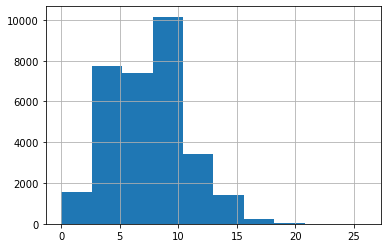

In [6]:
# Lets find out the no. of words in a tweets
# split the tweets into individual words 
tweets_words = tweets.apply(lambda x : x.split())
#plot the count of no. of words in a tweet
len_tw = pd.Series([len(tweet) for tweet in tweets_words])
len_tw.hist(bins=10)

# from the graph we see that the maximum length of a tweet is 26, and average is 12

# convert the tweets to a list of sentences
tweets_list = tweets.tolist()
#print(tweets_list)

label = label.tolist()  # convert to a list
label = np.array(label)  # convert to numpy array


tweets_train, tweets_test, label_train, label_test = train_test_split(tweets_list, label, test_size=0.3, random_state=100,
                                                                      stratify=label)


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc')
      ]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10, # wait till 10 epochs. can be increased later if needed
    mode='max',
    restore_best_weights=True)


# define the various parameters for the model
vocab_size = 1000  # take the 1000 most common words
embedding_dim = 16 # No. of features wanted eg. 16
max_length = 25   # max no. of words in a sentence

# define a tokenizer and train it on out list of words and sentences
tokenizer = Tokenizer(num_words=vocab_size , oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_list)
word_index = tokenizer.word_index
print("Length of word index = ", len(word_index))
#print(tokenizer.word_index["pics"])

# convert the list of sentenses to tokenized list of words
sentences_train = tokenizer.texts_to_sequences(tweets_train)
sentences_train = pad_sequences(sentences_train, maxlen=max_length, padding='post', truncating='post')
print(sentences_train)
print(sentences_train.shape)

sentences_test = tokenizer.texts_to_sequences(tweets_test)
sentences_test = pad_sequences(sentences_test, maxlen=max_length, padding='post', truncating='post')



In [7]:
# ******* lets check if the data is skewed *****************************
neg_count = df['label'].value_counts()[0]
pos_count = df['label'].value_counts()[1]
total = pos_count + neg_count

# we see that there are only 7% instances postitve, so we define an initial bias
initial_bias = np.log([pos_count/neg_count])
# Define an output bias that would be applied to the output layer of the model
output_bias = tf.keras.initializers.Constant(initial_bias)

# calculate class weights
weight_for_0 = (1/neg_count) * (total)/2.0
weight_for_1 = (1/pos_count) * (total)/2.0
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
# define the class-weight dictionary to be used for training the model
class_weight = {0:weight_for_0, 1:weight_for_1}

BATCH_SIZE=50
EPOCHS=20
LEARNING_RATE = 0.0001 # Default learning rate for the Adam optimizer is 0.001




Weight for class 0: 0.54
Weight for class 1: 7.13


In [8]:
# *************** Now we will use Subwords dataset with Bi-directional LSTM layers *********************
# define the subword tokenizer 
tokenizer_sub = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(tweets_list, vocab_size, max_subword_length=5)
print("Vocab size is ", tokenizer_sub.vocab_size)

# Replace sentence data with encoded subwords
for i, tweet in enumerate(tweets_list):
    tweets_list[i] = tokenizer_sub.encode(tweet)
    
print(tweets_list[0])

sentences_sub = pad_sequences(tweets_list, maxlen=max_length,padding='post',truncating='post')

sentences_train_sub, sentences_test_sub, label_train, label_test = train_test_split(sentences_sub, label, 
                                                                            test_size=0.3, 
                                                                            random_state=100,
                                                                            stratify=label)





Vocab size is  996
[67, 7, 840, 327, 303, 580, 58, 201, 570, 170, 772, 217, 232, 1, 622, 1, 840, 327, 303, 580, 53, 218, 850]


Epoch 1/25
448/448 [==============================] - 14s 19ms/step - loss: 1.3572 - accuracy: 0.9303 - auc: 0.4959
Epoch 2/25
448/448 [==============================] - 10s 23ms/step - loss: 1.3924 - accuracy: 0.9283 - auc: 0.4904
Epoch 3/25
448/448 [==============================] - 9s 20ms/step - loss: 1.4441 - accuracy: 0.9253 - auc: 0.4997
Epoch 4/25
448/448 [==============================] - 9s 20ms/step - loss: 1.3643 - accuracy: 0.9292 - auc: 0.5001
Epoch 5/25
448/448 [==============================] - 10s 22ms/step - loss: 1.3477 - accuracy: 0.9297 - auc: 0.4996
Epoch 6/25
448/448 [==============================] - 9s 20ms/step - loss: 1.2531 - accuracy: 0.9342 - auc: 0.4987
Epoch 7/25
448/448 [==============================] - 10s 22ms/step - loss: 1.3567 - accuracy: 0.9276 - auc: 0.4971
Epoch 8/25
448/448 [==============================] - 10s 22ms/step - loss: 1.3371 - accuracy: 0.9272 - auc: 0.4925
Epoch 9/25
448/448 [==============================] - 9s 19ms/step - loss: 

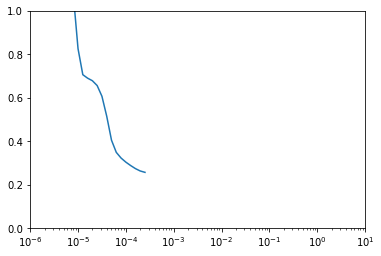

In [9]:

# *********************************************************************************************************
# We will try to optimize the lstm model using a learning-rate scheduler
# we will start with a very low learning rate of 1e-6 and after every 10 epochs we will multiply it by a power of 10
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 **(epoch/10))
reset_states = ResetStatesCallback()

# define the model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)    
    ])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=METRICS)

history = model.fit(sentences_train_sub, label_train, epochs=25, batch_size=BATCH_SIZE,
                             callbacks=[lr_schedule],
                             class_weight=class_weight
                             )

plt.figure()
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 10, 0, 1])
plt.show()







In [10]:
#%%

# from this graph we see that the best learning rate is between 1e-4 and 1e-3, so we would use 1e-4 
# earlier we were using 5e-4, but 1e-4 is giving beter resuts.
# Now we compile the model with the new learning rate and also save the best state of the model
model_final=None

model_final = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)    
    ])


model_final.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), metrics=METRICS)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint("my_checkpoint.h5",verbose=2, save_best_only=True, mode='auto')

history = model_final.fit(sentences_train_sub, label_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                       callbacks=[early_stopping, model_checkpoint],
                                       class_weight=class_weight)


plot_model(history)
#%%
model=None
model = tf.keras.models.load_model("my_checkpoint.h5")

preds = model.predict(x=sentences_test_sub)
# The closer the prediction is to 1, the more positive the review is
pred_labels = [1 if pred>0.5 else 0 for pred in preds]

print("F1 score= ", f1_score(label_test, pred_labels))
print("ROC AUC score = ", roc_auc_score(label_test, pred_labels))

# we get an f1 score of about 0.40


Epoch 1/20
448/448 [==============================] - 17s 23ms/step - loss: 1.1002 - accuracy: 0.8641 - auc: 0.8713


Epoch 2/20
448/448 [==============================] - 11s 25ms/step - loss: 0.5722 - accuracy: 0.7660 - auc: 0.8424


Epoch 3/20
448/448 [==============================] - 9s 21ms/step - loss: 0.3620 - accuracy: 0.8324 - auc: 0.9252


Epoch 4/20
448/448 [==============================] - 8s 19ms/step - loss: 0.3271 - accuracy: 0.8529 - auc: 0.9363


Epoch 5/20
448/448 [==============================] - 8s 19ms/step - loss: 0.3053 - accuracy: 0.8696 - auc: 0.9460


Epoch 6/20
448/448 [==============================] - 10s 21ms/step - loss: 0.2868 - accuracy: 0.8777 - auc: 0.9525


Epoch 7/20
448/448 [==============================] - 10s 21ms/step - loss: 0.2769 - accuracy: 0.8778 - auc: 0.9557


Epoch 8/20
448/448 [==============================] - 9s 21ms/step - loss: 0.2797 - accuracy: 0.8811 - auc: 0.9535


Epoch 9/20
448/448 [==============================] - 11s 24ms/step - loss: 0.2746 - accuracy: 0.8799 - auc: 0.9560


Epoch 10/20
448/448 [==============================] - 11s 24ms/step - loss: 0.2583 - accuracy: 0.8838 - auc: 0.9599


Epoch 11/20
448/448 [==============================] - 11s 24ms/step - loss: 0.2562 - accuracy: 0.8810 - auc: 0.9585


Epoch 12/20
448/448 [==============================] - 10s 21ms/step - loss: 0.2427 - accuracy: 0.8876 - auc: 0.9605


Epoch 13/20
448/448 [==============================] - 9s 20ms/step - loss: 0.2363 - accuracy: 0.8881 - auc: 0.9621


Epoch 14/20
448/448 [==============================] - 9s 20ms/step - loss: 0.2194 - accuracy: 0.8931 - auc: 0.9641


Epoch 15/20
448/448 [==============================] - 9s 20ms/step - loss: 0.2191 - accuracy: 0.8906 - auc: 0.9643


Epoch 16/20
448/448 [==============================] - 9s 19ms/step - loss: 0.2066 - accuracy: 0.9028 - auc: 0.9665


Epoch 17/20
448/448 [==============================] - 8s 19ms/step - loss: 0.2074 - accuracy: 0.8945 - auc: 0.9649


Epoch 18/20
448/448 [==============================] - 8s 19ms/step - loss: 0.2002 - accuracy: 0.9061 - auc: 0.9666


Epoch 19/20
448/448 [==============================] - 11s 25ms/step - loss: 0.1987 - accuracy: 0.9040 - auc: 0.96650s - loss: 0.1983 


Epoch 20/20
448/448 [==============================] - 10s 22ms/step - loss: 0.1989 - accuracy: 0.9072 - auc: 0.9666


KeyError: 'val_accuracy'

In [ ]:
# ********** for visualizing the emembeddings ****************

# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io
# Write out the embedding vectors and metadata
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()